In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# Load Data

In [2]:
df_cracks = pd.read_csv('/home/thmegy/Téléchargements/import_ai4cracks_200_CD33_tood.csv', sep=';')

In [3]:
df_cracks['id'] = df_cracks['route']+'_'+df_cracks['plo_debut']+'_'+\
                df_cracks['abs_debut'].astype('str')+'_'+df_cracks['plo_fin']+'_'+\
                df_cracks['abs_fin'].astype('str')

In [4]:
df_note = pd.read_csv('/home/thmegy/Téléchargements/Note rapide_CD33.csv', sep=';')

In [5]:
df_note['id'] = df_note['route']+'_'+df_note['plo_debut']+'_'+\
                df_note['abs_debut'].astype('str')+'_'+df_note['plo_fin']+'_'+\
                df_note['abs_fin'].astype('str')

In [7]:
df_cracks.columns

Index(['route', 'plo_debut', 'abs_debut', 'plo_fin', 'abs_fin', 'date',
       'Nb_Arrachement_pelade', 'Moy_Arrachement_pelade', 'Nb_Faiencage',
       'Moy_Faiencage', 'Nb_Nid_de_poule', 'Moy_Nid_de_poule',
       'Nb_Transversale', 'Moy_Transversale', 'Nb_Longitudinale',
       'Moy_Longitudinale', 'Nb_Pontage_de_fissures',
       'Moy_Pontage_de_fissures', 'Nb_Comblage_de_trou_ou_Projection_d_enrobe',
       'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
       'Nb_Remblaiement_de_tranchees', 'Moy_Remblaiement_de_tranchees', 'id'],
      dtype='object')

In [19]:
col = ['Moy_Pontage_de_fissures', 'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
       'Moy_Longitudinale', 'Moy_Transversale',
       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade',
       'Moy_Remblaiement_de_tranchees', 'id']

df_new = pd.merge(df_note.iloc[:,-2:], df_cracks[col], on='id')

In [9]:
train_test_split_id = int(0.8 * df_new.shape[0])
df_new.to_csv('/home/thmegy/Téléchargements/CD33_AI4Cracks_notes.csv', index=False)
df_new.iloc[:train_test_split_id].to_csv('/home/thmegy/Téléchargements/CD33_AI4Cracks_notes_train.csv', index=False)
df_new.iloc[train_test_split_id:].to_csv('/home/thmegy/Téléchargements/CD33_AI4Cracks_notes_test.csv', index=False)

<AxesSubplot:>

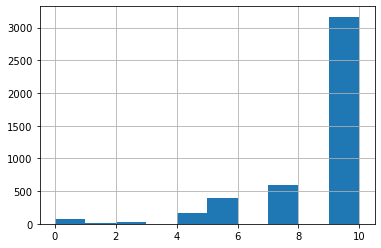

In [10]:
df_new['NOTE'].hist()

In [11]:
df_new['NOTE'].mean()

8.71410835214447

In [12]:
np.unique(df_new['NOTE'])

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  7.5, 10. ])

<AxesSubplot:>

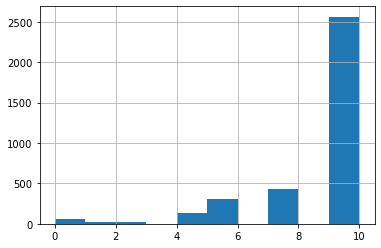

In [13]:
df_new['NOTE'].iloc[:train_test_split_id].hist()

<AxesSubplot:>

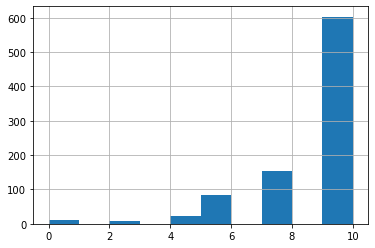

In [14]:
df_new['NOTE'].iloc[train_test_split_id:].hist()

In [15]:
mask = df_new['NOTE'] >= 7
df_new[mask].mean()

NOTE                                           9.556280
Moy_Pontage_de_fissures                        0.205645
Moy_Comblage_de_trou_ou_Projection_d_enrobe    0.117391
Moy_Longitudinale                              0.882132
Moy_Transversale                               0.620975
Moy_Nid_de_poule                               0.126290
Moy_Faiencage                                  0.593442
Moy_Arrachement_pelade                         0.976800
Moy_Remblaiement_de_tranchees                  0.186077
dtype: float64

In [16]:
mask = df_new['NOTE'] < 7
df_new[mask].mean()

NOTE                                           4.004464
Moy_Pontage_de_fissures                        0.289057
Moy_Comblage_de_trou_ou_Projection_d_enrobe    0.141137
Moy_Longitudinale                              0.962243
Moy_Transversale                               0.795595
Moy_Nid_de_poule                               0.144938
Moy_Faiencage                                  0.815669
Moy_Arrachement_pelade                         0.978974
Moy_Remblaiement_de_tranchees                  0.261043
dtype: float64

In [22]:
col = ['Moy_Pontage_de_fissures', 'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
       'Moy_Longitudinale', 'Moy_Transversale', 'Moy_Remblaiement_de_tranchees',
       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade',
      'NOTE']
#col = ['Nb_Reparation', 'Nb_Longitudinale', 'Nb_Transversale',
#       'Nb_Nid_de_poule', 'Nb_Faiencage', 'Nb_Arrachement_pelade',
#      'NOTE']

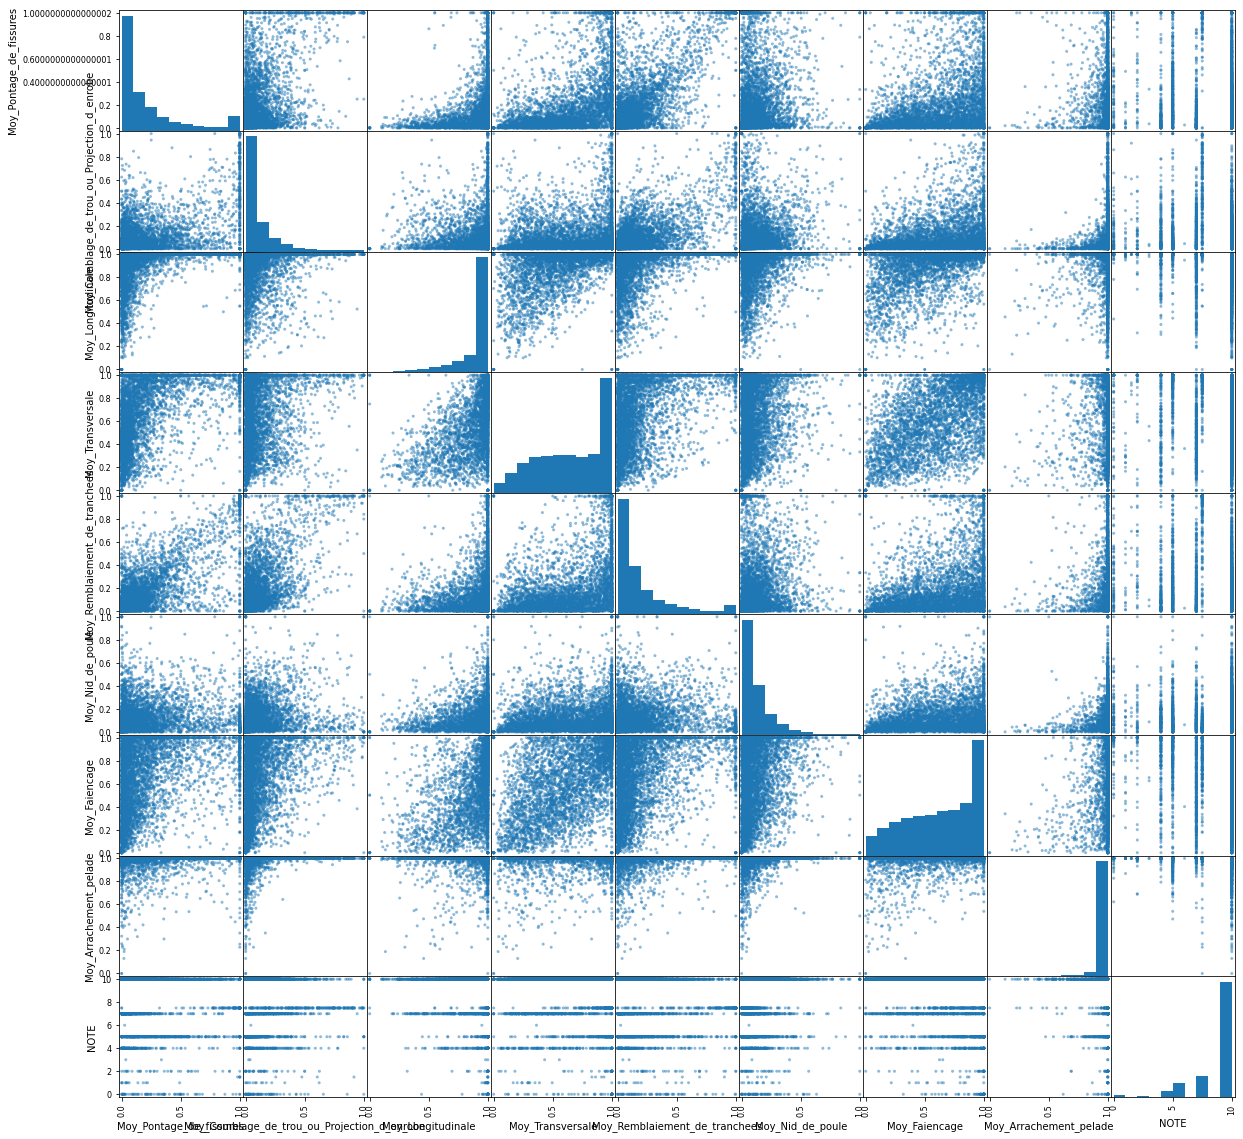

In [23]:
pl = pd.plotting.scatter_matrix(df_new[col], figsize=(20,20))

In [24]:
col = ['Moy_Pontage_de_fissures', 'Moy_Comblage_de_trou_ou_Projection_d_enrobe',
       'Moy_Longitudinale', 'Moy_Transversale', 'Moy_Remblaiement_de_tranchees',
       'Moy_Nid_de_poule', 'Moy_Faiencage', 'Moy_Arrachement_pelade']
df_new['Moy_sum'] = df_new[col].sum(axis=1)

In [38]:
def note_vs_degradation(degr):
    plt.figure(figsize=(12,8))
    matrix, bins_x, bins_y = np.histogram2d(df_new[degr], df_new['NOTE'], bins=(10, 5))

    matrix = matrix / matrix.sum(axis=0)
    print(matrix.T)
    plt.pcolor(matrix.T, cmap='Greens')
    plt.xticks(ticks=range(len(bins_x)), labels=bins_x)
    plt.yticks(ticks=range(len(bins_y)), labels=bins_y)
    plt.xlabel('Moyenne degradation')
    plt.ylabel('Note')
    plt.colorbar()
    plt.show()

[[0.37647059 0.29411765 0.15294118 0.07058824 0.02352941 0.05882353
  0.01176471 0.         0.         0.01176471]
 [0.5        0.11111111 0.16666667 0.11111111 0.05555556 0.02777778
  0.         0.         0.         0.02777778]
 [0.50545455 0.28363636 0.11090909 0.04181818 0.03272727 0.01272727
  0.00363636 0.00181818 0.00363636 0.00363636]
 [0.56418919 0.27364865 0.08952703 0.03209459 0.02027027 0.01182432
  0.00168919 0.00337838 0.00168919 0.00168919]
 [0.56583518 0.22576571 0.09977897 0.05715188 0.02305021 0.01547206
  0.00599937 0.00221029 0.00094727 0.00378907]]


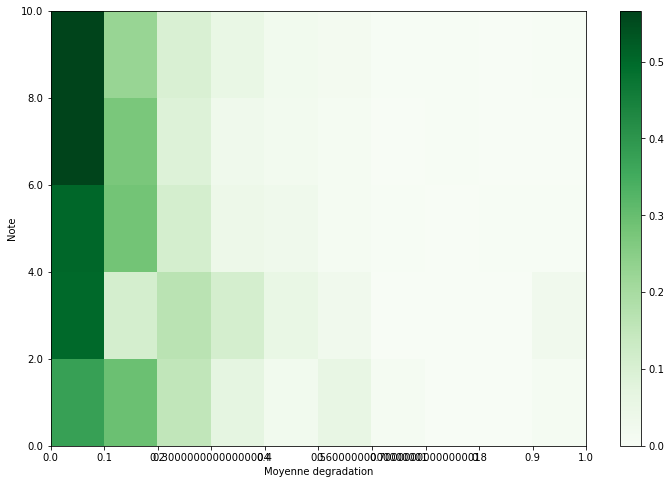

In [39]:
note_vs_degradation('Moy_Nid_de_poule')

[[0.         0.         0.01176471 0.02352941 0.03529412 0.07058824
  0.08235294 0.03529412 0.10588235 0.63529412]
 [0.02777778 0.02777778 0.05555556 0.02777778 0.02777778 0.02777778
  0.08333333 0.05555556 0.05555556 0.61111111]
 [0.01636364 0.02363636 0.02909091 0.02545455 0.03636364 0.04727273
  0.05636364 0.09636364 0.13454545 0.53454545]
 [0.03716216 0.0472973  0.07094595 0.08108108 0.09459459 0.09121622
  0.11486486 0.11317568 0.13006757 0.21959459]
 [0.05146827 0.07199242 0.0836754  0.09409536 0.09725292 0.09567414
  0.101042   0.09977897 0.10925166 0.19576887]]


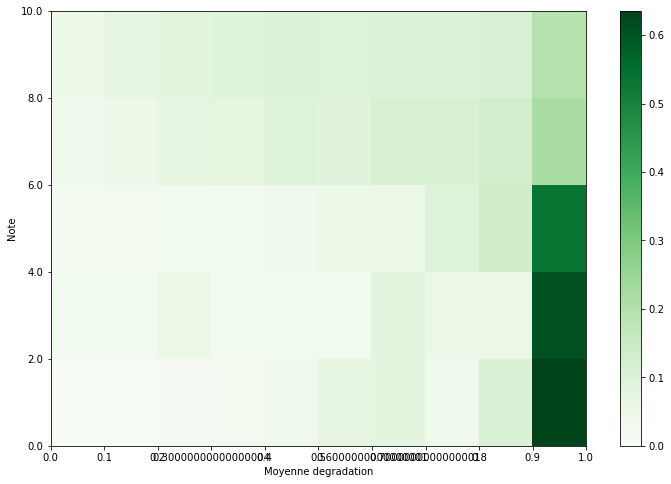

In [40]:
note_vs_degradation('Moy_Faiencage')

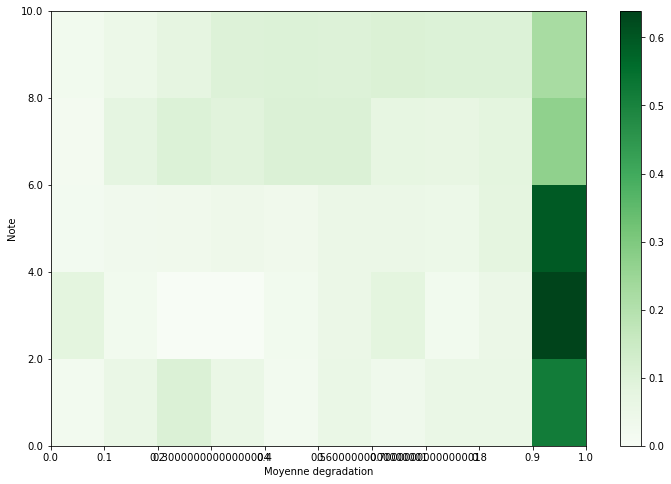

In [28]:
note_vs_degradation('Moy_Transversale')

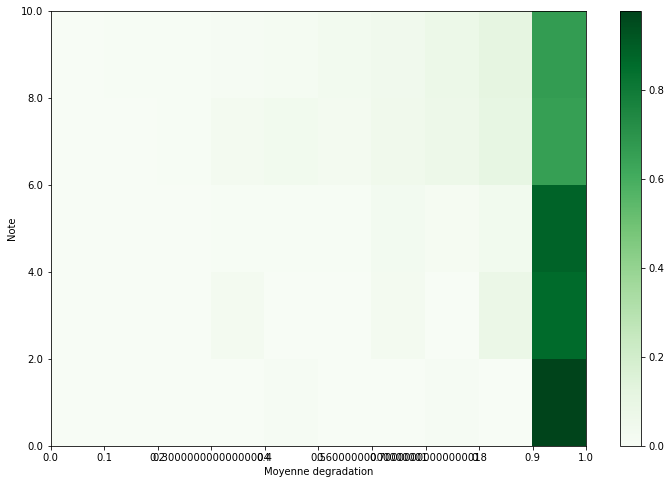

In [32]:
note_vs_degradation('Moy_Longitudinale')

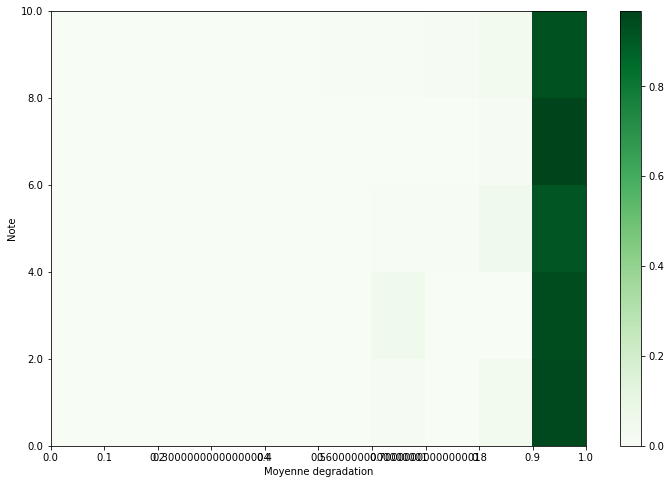

In [33]:
note_vs_degradation('Moy_Arrachement_pelade')

In [34]:
note_vs_degradation('Moy_Reparation')

KeyError: 'Moy_Reparation'

<Figure size 864x576 with 0 Axes>

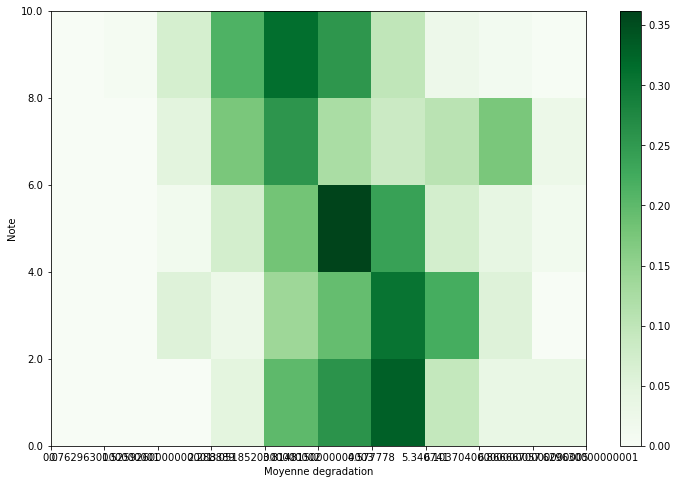

In [35]:
note_vs_degradation('Moy_sum')

In [196]:
class CustomDataset(Dataset):
    def __init__(self, path, device, augmentation=None):
        df = pd.read_csv(path)

        x = df.iloc[:,2:].values
        y = df['NOTE'].values
        y /= 10 # grade between 0 and 1                                                                  

        self.x=torch.tensor(x,dtype=torch.float32, device=device)
        self.y=torch.tensor(y,dtype=torch.float32, device=device)[:, None]
        
        self.augmentation = augmentation

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.augmentation is None:
            return self.x[idx],self.y[idx]
        else:
            return self.augmentation(self.x[idx]), self.augmentation(self.y[idx])

def gaussian_noise(x):
    return torch.clamp( torch.normal(x, 0.01), min=0, max=1)

In [197]:
d = CustomDataset('/home/thmegy/Téléchargements/CD33_AI4Cracks_notes_train.csv', device, augmentation=gaussian_noise)

In [240]:
a = d[10]
a

(tensor([0.2062, 0.2291, 0.1320, 0.0760, 0.0035, 0.0235]), tensor([0.5010]))

In [194]:
torch.clamp(a[0], min=0, max=1)

tensor([0.2182, 0.2246, 0.1380, 0.0611, 0.0000, 0.0228])

In [247]:
((10-df_new["NOTE"][:700].mean())/10)**2

0.008582698979591841